In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

In [44]:
def load_file(filename):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,0]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work, i_steals, i_steals

directory = "/home/khatiri/these/projet/ws-simulator/Simulation/simulation/simulation/"


data = load_file(directory + "new_vss_proba_32_100000000_finition")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")




ValueError: too many values to unpack (expected 5)

In [42]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))

    for cle in all_average:
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [6]:
def plot_for_best(filename):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
        best_avg_overhead = compute_overhead(data, int(latence), minimum)
        best[latence] = best_avg_overhead
        if minimum < 1:
            base_line[latence] = compute_overhead(data, int(latence), 0.5)
            #print(latence, minimum)
    
    return best, base_line

In [7]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [8]:
def best_overhead_dict(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

In [9]:
def best_value_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (16,32,64,128,256):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum] + overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



In [10]:
best_w, best_p, best_l = best_value_dict(directory, 1)


# A faire  :

Tourner des résultats pour rsp entre 0.001 et 0.02 pour bien tracer les courbes

Afficher l'interval de confiance


## overhead en fonction proba 

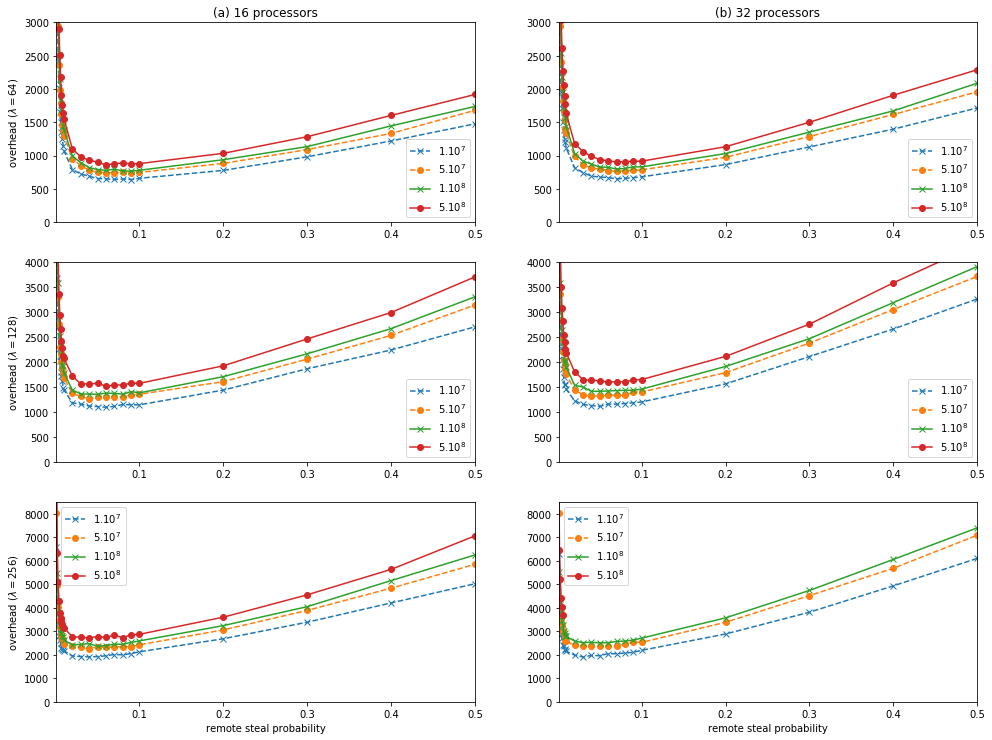

In [11]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

plt.subplot(321)
plt.xlim(0.001, 0.5)
#plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 64$)")
plt.title("(a) 16 processors")

plt.ylim(0, 3000)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()

plt.legend()
plt.subplot(322)
plt.xlim(0.001, 0.5)
plt.ylim(0, 3000)
plt.title("(b) 32 processors")

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

#------- 128

plt.subplot(323)
plt.xlim(0.001, 0.5)
plt.ylabel("overhead ($\lambda = 128$)")

plt.ylim(0, 4000)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(324)
plt.xlim(0.001, 0.5)
plt.ylim(0, 4000)

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")
data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()


#------- 256
plt.subplot(325)
plt.xlim(0.001, 0.5)
plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 256$)")

plt.ylim(0, 8500)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(326)
plt.xlim(0.001, 0.5)
plt.ylim(0, 8500)
plt.xlabel("remote steal probability")

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_rsp_l.pdf',bbox_inches='tight')

besoin de resultat pour latence 512 et w = 500000000
besoin de resultat pour latence 256 et w = 500000000


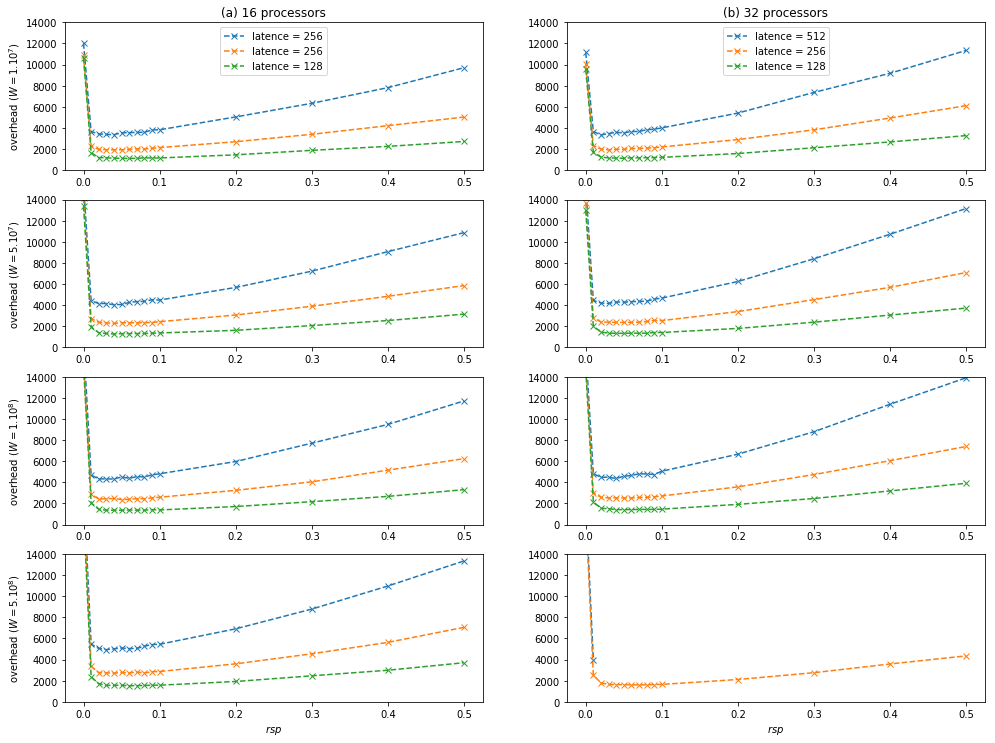

In [11]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

data = load_file(directory + "vss_proba_16_10000000")
plt.subplot(421)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 1.10^7$)")

plt.title("(a) 16 processors")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)


plt.subplot(422)
plt.title("(b) 32 processors")
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_10000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


#---- ligne 2

data = load_file(directory + "vss_proba_16_50000000")
plt.subplot(423)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 5.10^7$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)


plt.subplot(424)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_50000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)


#---- ligne 3

data = load_file(directory + "vss_proba_16_100000000")
plt.subplot(425)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 1.10^8$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)


plt.subplot(426)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_100000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)


#---- ligne 4

data = load_file(directory + "vss_proba_16_500000000")
plt.subplot(427)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 5.10^8$)")
plt.xlabel("$rsp$")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)


plt.subplot(428)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_500000000")
plt.xlabel("$rsp$")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)
#_, overhead, minimum = compute_overhead_for_latence(data, 128)
#plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")

print("besoin de resultat pour latence 512 et w = 500000000")
print("besoin de resultat pour latence 256 et w = 500000000")


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_rsp_w.pdf',bbox_inches='tight')

In [188]:
best_w, best_p, best_l = best_value_dict(directory, 2)


#en fonction $W$


10000000 [0.02, 0.03, 0.04, 0.05]
50000000 [0.04]
100000000 [0.05, 0.06]
500000000 [0.02, 0.03, 0.04, 0.06, 0.08]


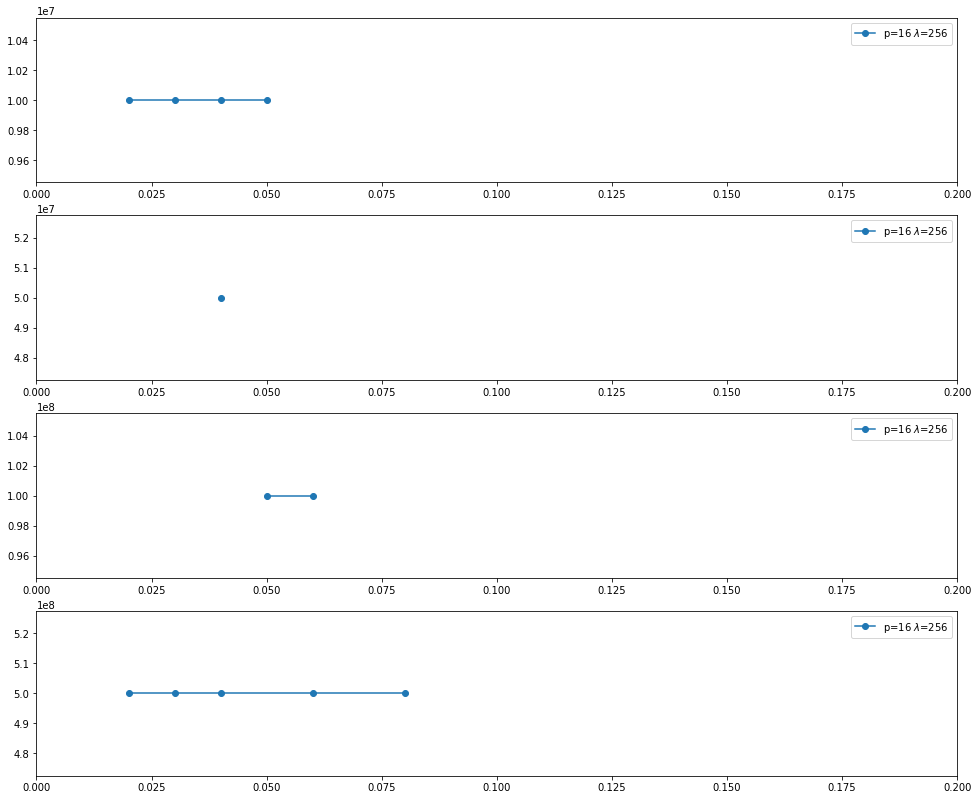

In [172]:
fig = plt.figure()
fig.set_size_inches(16.5, 28.5, forward=True)

a = 811
for k in best_w.keys():
    if k[0] == 16 and k[1] in [256]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.2)
            a += 1
            print(i, best_w[k][i])
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="p="+str(k[0])+" $\lambda$="+str(k[1]))
            plt.legend()

    #if k[0] == 32 and k[1] in [64,128,256,512]:
        #plt.subplot(122)
        #plt.ylim(0, 0.11)
        #print(k, best_w[k].values())
        #plt.plot(best_w[k].keys(), best_w[k].values(), "o-", label="p="+str(k[0])+" $\lambda$="+str(k[1]))
        #plt.legend()


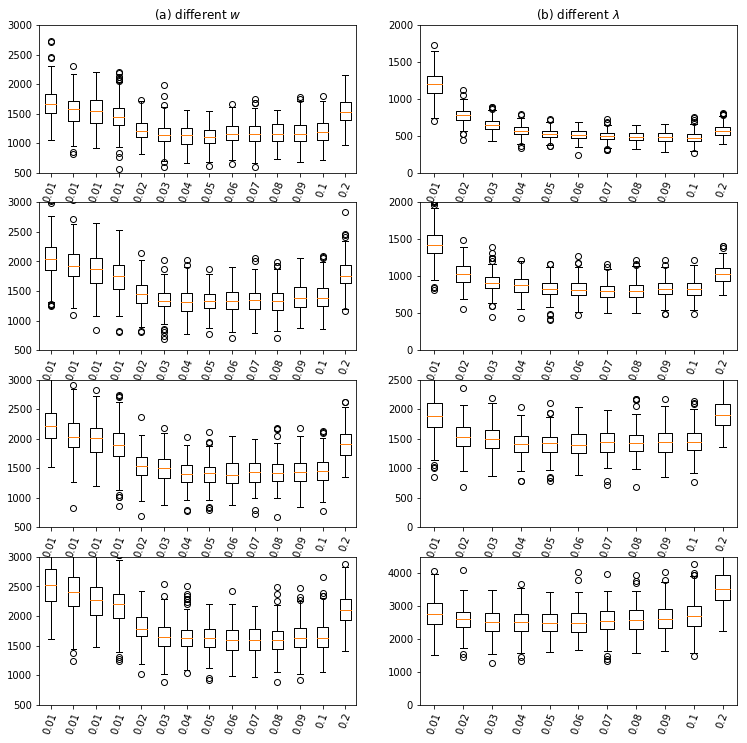

In [81]:
def boxdata(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_proba_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,2) for x in all_average.keys() if rspmin <= x and x <= rspmax]
    
fig = plt.figure()
fig.set_size_inches(12.5, 12.5, forward=True)

list_avrg, list_keys = boxdata(32, 10000000, 128, 0.007, 0.2)
plt.subplot(421)
plt.title("(a) different $w$")
plt.ylim(500, 3000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 50000000, 128, 0.007, 0.2)
plt.subplot(423)
plt.ylim(500, 3000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 128, 0.007, 0.2)
plt.subplot(425)
plt.ylim(500, 3000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 500000000, 128, 0.007, 0.2)
plt.subplot(427)
plt.ylim(500, 3000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

#----------------

list_avrg, list_keys = boxdata(32, 100000000, 32, 0.01, 0.2)
plt.subplot(422)
plt.title("(b) different $\lambda$")
plt.ylim(0, 2000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 100000000, 64, 0.01, 0.2)
plt.subplot(424)
plt.ylim(0, 2000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 128, 0.01, 0.2)
plt.subplot(426)
plt.ylim(0, 2500)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 256, 0.01, 0.2)
plt.subplot(428)
plt.ylim(0, 4500)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_rsp_w.pdf',bbox_inches='tight')


#plt.ylim(1800, 2250)
#plt.xlim(0.01, 0.07)
#plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


#en fonction $latence$


16 [0.09, 0.1]
32 [0.08, 0.09]
64 [0.07, 0.08]
128 [0.04, 0.05]
256 [0.03]


' \n    if k[0] == 50000000 and k[1] ==16:\n        for i in best_l[k].keys():\n            plt.subplot(a)\n            plt.xlim(0, 0.5)\n            a += 1\n            print(i, best_l[k][i])\n            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="p="+str(k[0])+" $\\lambda$="+str(i))\n            plt.legend()\n\n    if k[0] == 100000000 and k[1] ==16:\n        plt.subplot(121)\n        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))\n    if k[0] == 500000000 and k[1] ==16:\n        plt.subplot(121)\n        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))\n        plt.legend()\n    if k[0] == 10000000 and k[1] == 32:\n        plt.subplot(122)\n        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))\n        plt.legend()\n    if k[0] == 50000000 and k[1] == 32:\n        plt.subplot(122)\n        plt.plot(best_l[k].keys(), best_

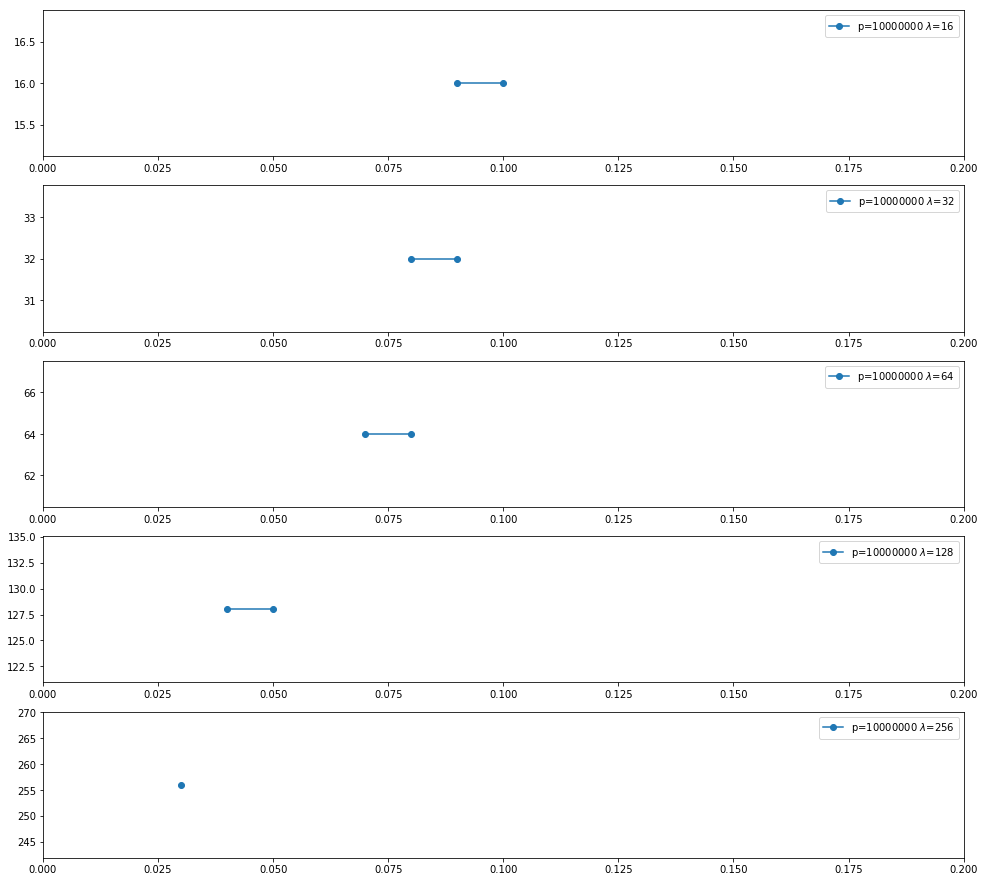

In [194]:
fig = plt.figure()
fig.set_size_inches(16.5, 28.5, forward=True)
a = 911
for k in best_l.keys():
    if k[0] == 10000000 and k[1] ==32:
        for i in best_l[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.2)
            a += 1
            print(i, best_l[k][i])
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="p="+str(k[0])+" $\lambda$="+str(i))
            plt.legend()
""" 
    if k[0] == 50000000 and k[1] ==16:
        for i in best_l[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.5)
            a += 1
            print(i, best_l[k][i])
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="p="+str(k[0])+" $\lambda$="+str(i))
            plt.legend()

    if k[0] == 100000000 and k[1] ==16:
        plt.subplot(121)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
    if k[0] == 500000000 and k[1] ==16:
        plt.subplot(121)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
        plt.legend()
    if k[0] == 10000000 and k[1] == 32:
        plt.subplot(122)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
        plt.legend()
    if k[0] == 50000000 and k[1] == 32:
        plt.subplot(122)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
        plt.legend()
    if k[0] == 100000000 and k[1] == 32:
        plt.subplot(122)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
        plt.legend()
    if k[0] == 500000000 and k[1] == 32:
        plt.subplot(122)
        plt.plot(best_l[k].keys(), best_l[k].values(), "o-", label="w="+str(k[0])+" p="+str(k[1]))
        plt.legend()
"""

16 [0.09, 0.1]
32 [0.09, 0.1]
64 [0.06, 0.07, 0.08, 0.09, 0.1]
128 [0.05, 0.06, 0.07, 0.08]
256 [0.006]


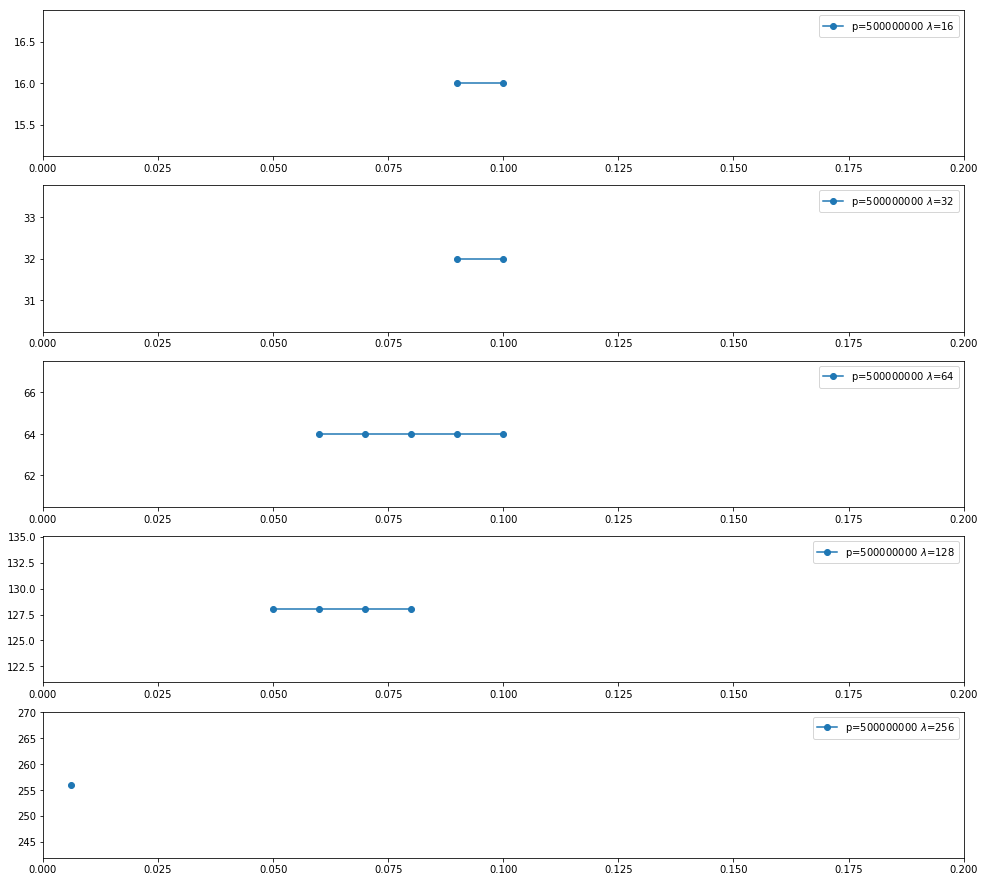

In [196]:
fig = plt.figure()
fig.set_size_inches(16.5, 28.5, forward=True)
a = 911
for k in best_l.keys():
    if k[0] == 500000000 and k[1] ==32:
        for i in best_l[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.2)
            a += 1
            print(i, best_l[k][i])
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="p="+str(k[0])+" $\lambda$="+str(i))
            plt.legend()

#en fonction $Proc\_number$


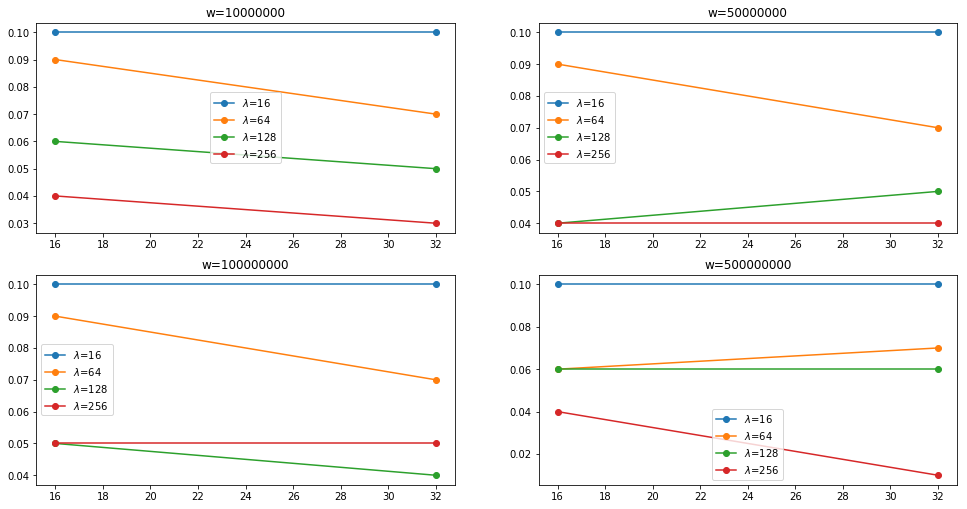

In [15]:
fig = plt.figure()
fig.set_size_inches(16.5, 8.5, forward=True)

for k in best_p.keys():
    if k[0] == 10000000 and k[1] in [16,64,128,256,512]:
        plt.subplot(221)
        plt.plot(best_p[k].keys(), best_p[k].values(), "o-", label="$\lambda$="+str(k[1]))
        plt.title("w="+str(k[0]))
        plt.legend()
        
    if k[0] == 50000000 and k[1] in [16,64,128,256,512]:
        plt.subplot(222)
        plt.plot(best_p[k].keys(), best_p[k].values(), "o-", label="$\lambda$="+str(k[1]))
        plt.title("w="+str(k[0]))
        plt.legend()
    
    if k[0] == 100000000 and k[1] in [16,64,128,256,512]:
        plt.subplot(223)
        plt.plot(best_p[k].keys(), best_p[k].values(), "o-", label="$\lambda$="+str(k[1]))
        plt.title("w="+str(k[0]))
        plt.legend()
        
    if k[0] == 500000000 and k[1] in [16,64,128,256,512]:
        plt.subplot(224)
        plt.plot(best_p[k].keys(), best_p[k].values(), "o-", label="$\lambda$="+str(k[1]))
        plt.title("w="+str(k[0]))
        plt.legend()



In [16]:
"""
fig = plt.figure()
fig.set_size_inches(16.5, 8.5, forward=True)


#plt.subplot(221)
best = latence_for_best_param(directory + "vss_static_32_500000000")
plt.plot(best.keys(), best.values(), "s-", label="32_500000000")

best = latence_for_best_param(directory + "vss_static_32_100000000")
plt.plot(best.keys(), best.values(), "x-", label="32_100000000")

best = latence_for_best_param(directory + "vss_static_32_50000000")
plt.plot(best.keys(), best.values(), "+-", label="32_50000000")

best = latence_for_best_param(directory + "vss_static_32_10000000")
plt.plot(best.keys(), best.values(), "*-", label="32_10000000")
plt.legend()

plt.subplot(222)
best = latence_for_best_param(directory + "vss_static_16_500000000")
plt.plot(best.keys(), best.values(), "s--", label="16_500000000")

best = latence_for_best_param(directory + "vss_static_16_100000000")
plt.plot(best.keys(), best.values(), "x--", label="16_100000000")

best = latence_for_best_param(directory + "vss_static_16_50000000")
plt.plot(best.keys(), best.values(), "+--", label="16_50000000")

best = latence_for_best_param(directory + "vss_static_16_10000000")
plt.plot(best.keys(), best.values(), "*--", label="16_10000000")
plt.legend()
"""

'\nfig = plt.figure()\nfig.set_size_inches(16.5, 8.5, forward=True)\n\n\n#plt.subplot(221)\nbest = latence_for_best_param(directory + "vss_static_32_500000000")\nplt.plot(best.keys(), best.values(), "s-", label="32_500000000")\n\nbest = latence_for_best_param(directory + "vss_static_32_100000000")\nplt.plot(best.keys(), best.values(), "x-", label="32_100000000")\n\nbest = latence_for_best_param(directory + "vss_static_32_50000000")\nplt.plot(best.keys(), best.values(), "+-", label="32_50000000")\n\nbest = latence_for_best_param(directory + "vss_static_32_10000000")\nplt.plot(best.keys(), best.values(), "*-", label="32_10000000")\nplt.legend()\n\nplt.subplot(222)\nbest = latence_for_best_param(directory + "vss_static_16_500000000")\nplt.plot(best.keys(), best.values(), "s--", label="16_500000000")\n\nbest = latence_for_best_param(directory + "vss_static_16_100000000")\nplt.plot(best.keys(), best.values(), "x--", label="16_100000000")\n\nbest = latence_for_best_param(directory + "vss_sta

# A faire :

tourner des simulations entre avec max_internal_steal entre {0 40} pour savoir une courbe bien precis

Afficher l'interface de confiance

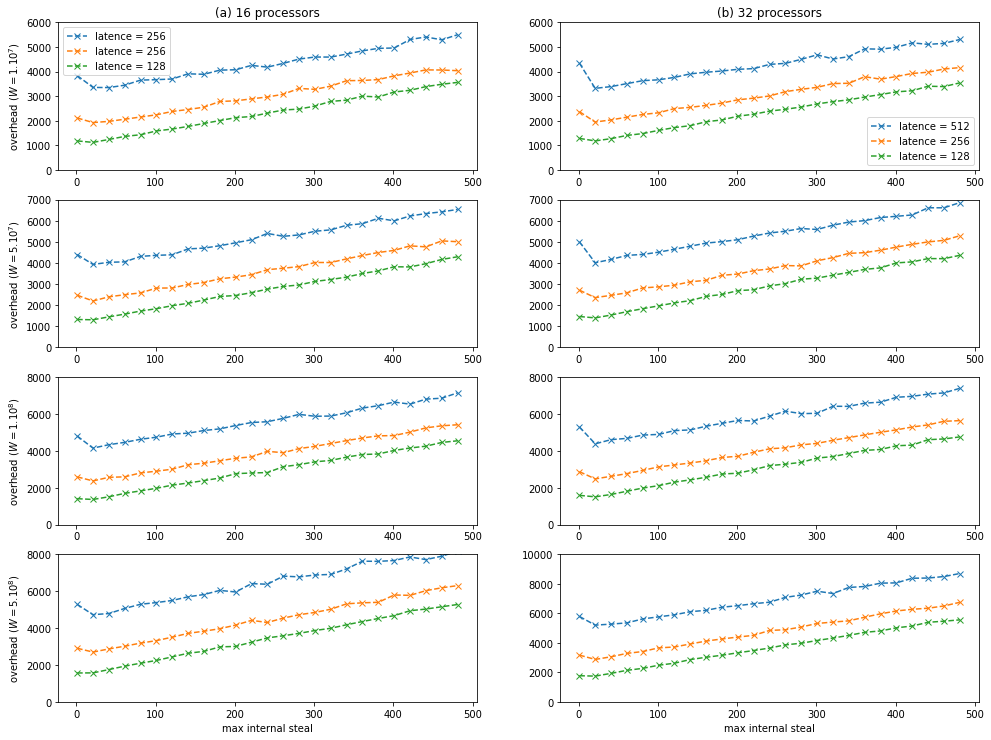

In [17]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

data = load_file(directory + "vss_static_16_10000000")
plt.subplot(421)
plt.ylim(0,6000)
plt.ylabel("overhead ($W = 1.10^7$)")

plt.title("(a) 16 processors")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)


plt.subplot(422)
plt.title("(b) 32 processors")
plt.ylim(0,6000)
data = load_file(directory + "vss_static_32_10000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)


_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)


#---- ligne 2

data = load_file(directory + "vss_static_16_50000000")
plt.subplot(423)
plt.ylim(0,7000)
plt.ylabel("overhead ($W = 5.10^7$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)


plt.subplot(424)
plt.ylim(0,7000)
data = load_file(directory + "vss_static_32_50000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)


#---- ligne 3

data = load_file(directory + "vss_static_16_100000000")
plt.subplot(425)
plt.ylim(0,8000)
plt.ylabel("overhead ($W = 1.10^8$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)


plt.subplot(426)
plt.ylim(0,8000)
data = load_file(directory + "vss_static_32_100000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)


#---- ligne 4

data = load_file(directory + "vss_static_16_500000000")
plt.subplot(427)
plt.ylim(0,8000)
plt.ylabel("overhead ($W = 5.10^8$)")
plt.xlabel("max internal steal")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)


plt.subplot(428)
plt.ylim(0,10000)
plt.xlabel("max internal steal")
data = load_file(directory + "vss_static_32_500000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_w.pdf',bbox_inches='tight')

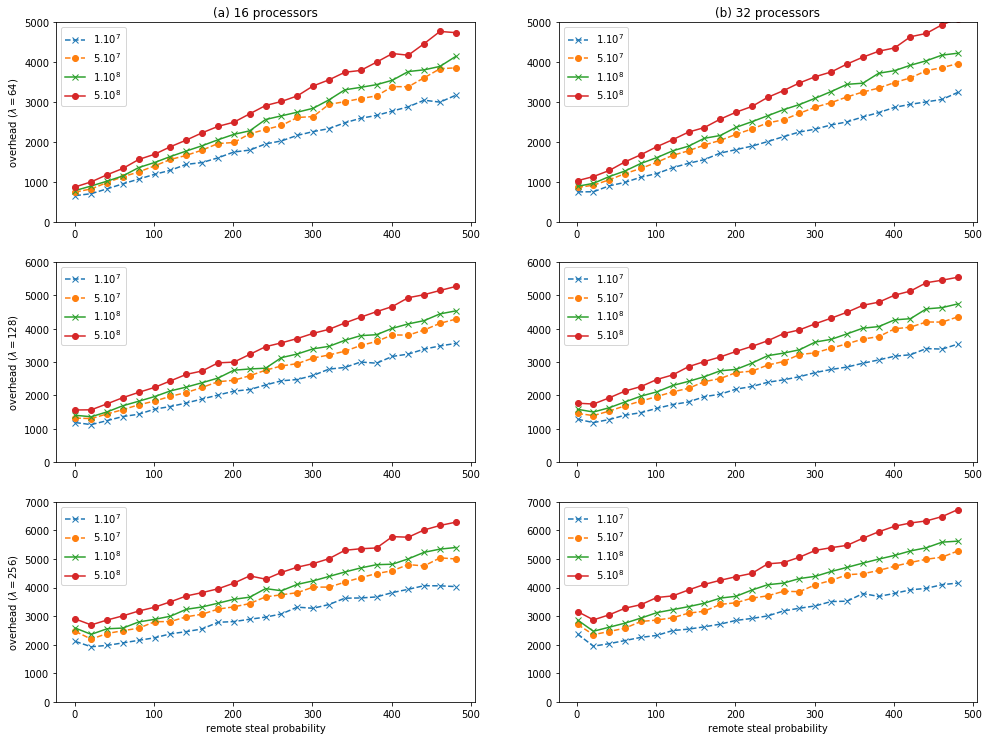

In [18]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

plt.subplot(321)
#plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 64$)")
plt.title("(a) 16 processors")

plt.ylim(0, 5000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()

plt.legend()
plt.subplot(322)
plt.ylim(0, 5000)
plt.title("(b) 32 processors")

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

#------- 128

plt.subplot(323)
plt.ylabel("overhead ($\lambda = 128$)")

plt.ylim(0, 6000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(324)
plt.ylim(0, 6000)

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")
data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()


#------- 256
plt.subplot(325)
plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 256$)")

plt.ylim(0, 7000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(326)
plt.ylim(0, 7000)

plt.xlabel("remote steal probability")

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_l.pdf',bbox_inches='tight')

In [19]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory + "vss_static_16_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(221)
plt.title("(a) 16 processors")
plt.ylabel("overhead")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($\rsp=0.5$)")

plt.legend()

plt.subplot(223)
plt.ylabel("overhead gains")

plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
plt.legend()

#---- 32 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory + "vss_proba_32_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory + "vss_static_32_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(222)
plt.title("(a) 32 processors")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($\rsp=0.5$)")

plt.legend()

plt.subplot(224)
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_vs_static_for_best_config.pdf',bbox_inches='tight')

ValueError: 
base_line ($sp=0.5$)
           ^
Expected end of text (at char 11), (line:1, col:12)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdf369a7950> (for post_execute):


ValueError: 
base_line ($sp=0.5$)
           ^
Expected end of text (at char 11), (line:1, col:12)

ValueError: 
base_line ($sp=0.5$)
           ^
Expected end of text (at char 11), (line:1, col:12)

<Figure size 1332x756 with 4 Axes>

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.pl.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_80.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(0%) / proba_Ov(0%)")

plt.legend()

# a faire : 

- Separer les courbes, les decrires,

- afficher les intervals de confiance

- mettre a jour les courbes avec les nouveaux dimulation


## amount of work steal (80% vs 50%)
we plot the overhead according to the latency for best parametre "$rsp$" or "$max\ internal\ steal$" 

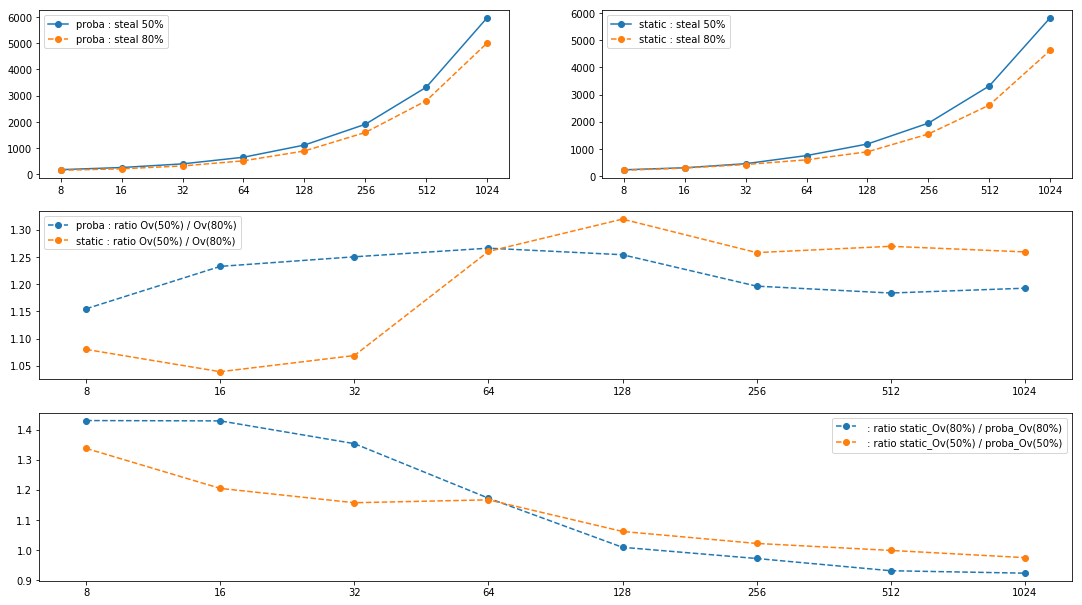

In [31]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

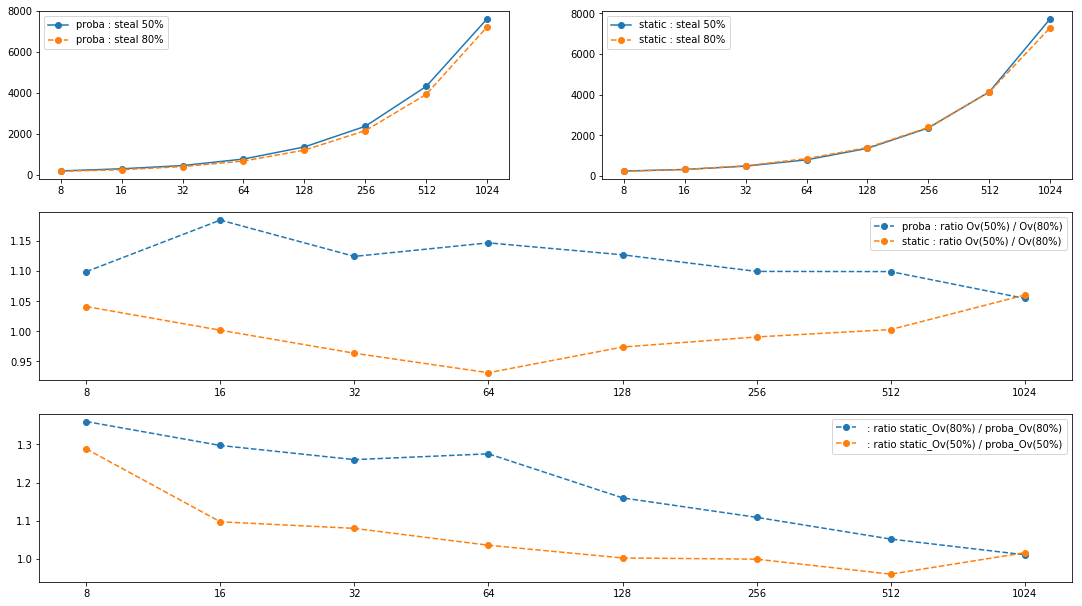

In [32]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

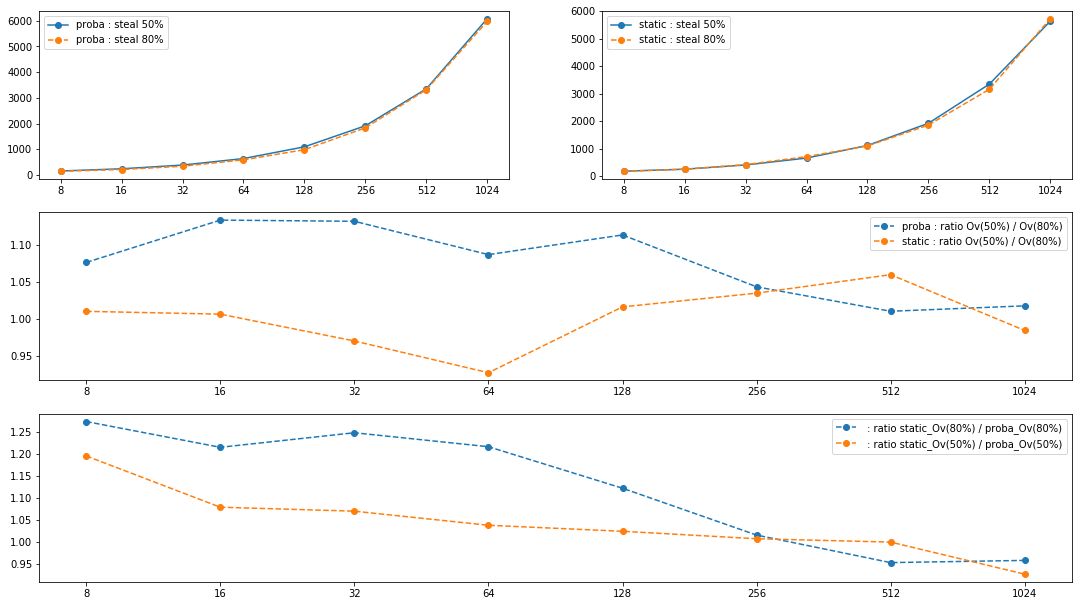

In [14]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

# A faire :

- tourner plus de resultats pour clarifier les choses
- tourner des resultats pour les autres strategies